In [1]:
# Qradratic Program solver for tracking problems
%matplotlib notebook
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mp
import matplotlib.animation as animation
import IPython

np.set_printoptions(precision=5,linewidth=120,suppress=True)

import cvxopt

class Quadrotor2D:
    """
    This class describes a 2D quadrotor model 
    """
    
    def __init__(self):
    
        #gravity constant
        self.g=9.81

        #integration step
        self.dt = 0.01
        
        #we define radius and masses
        self.r = 0.15
        self.m = 5.0
        
        # Define constant A, B for system dynamic equation
        self.A = np.array([[1.,0.,0.,self.dt,0.,0.],[0.,1.,0.,0.,self.dt,0.],[0.,0.,1.,0.,0.,self.dt],[0.,0.,-self.dt*self.g,1.,0.,0.],
                   [0.,0.,0.,0.,1.,0.],[0.,0.,0.,0.,0.,1.]])
        self.B = np.array([0.,0.,0.,0.,0.,0.,0.,0.,self.dt/self.m,0.,0,self.dt/(self.m*self.r**2)])
        self.B = self.B.reshape(6,2)
            
    def next_state(self,z,u):
        """
        Inputs:
        z: state of the 2d quadrotor syste as a numpy array (x,y,theta,v_x,v_y,omega)
        u: thrust forces as a numpy array (u1,u2)
        
        Output:
        the new state of the pendulum as a numpy array
        """
        x = z[0]
        y = z[1]
        th = z[2]
        v_x = z[3]
        v_y = z[4]
        om = z[5]
#         x_next = x + self.dt * v_x + 0.5 * self.dt**2 * ((u[0]* np.sin(th))/self.m)
#         y_next = y + self.dt * v_y + 0.5 * self.dt**2 * (-self.g + (u[0]*np.cos(th))/self.m)
#         th_next = th + self.dt * om + 0.5 * self.dt**2 * u[1]/(self.m*self.r**2)
        x_next = x + self.dt * v_x 
        y_next = y + self.dt * v_y 
        th_next = th + self.dt * om 
        v_x_next = v_x - self.dt * ((u[0]* np.sin(th))/self.m)
        v_y_next = v_y + self.dt * (-self.g + (u[0]*np.cos(th))/self.m)
        w_next = om + self.dt * u[1]/(self.m*self.r**2)
        z = np.array([x_next,y_next,th_next,v_x_next,v_y_next,w_next])
        return z
    
    def simulate(self, z0, K, uff, horizon_length):
        """
        This function simulates the quadrotor of horizon_length steps from initial state x0
        
        Inputs:
        z0: the initial conditions of the 2D quadrotor as a numpy array (x,y,theta,v_x,v_y,omega)
        controller: a function that takes a state z as argument and index i of the time step and returns a control u
        horizon_length: the horizon length
        
        Output:
        z[6x(time_horizon+1)] and u[2,time_horizon] containing the time evolution of states and controls
        """
        uoff = np.array([[self.g * self.m, 0.]]) # To simulate original quadrotor dynamics remember to add u0 = [mg 0]!
        z=np.empty([6, horizon_length+1])
        z[:,0] = z0
        u=np.empty([2,horizon_length])
        for i in range(horizon_length):
            u[:,i] = uoff + K[i].dot(z[:,i]) + uff[i]
            z[:,i+1] = self.next_state(z[:,i], u[:,i])
        return z, u 

In [2]:
def animate_2Dquadrotor_2(z,z_des,dt):
    """
    This function makes an animation showing the behavior of the cart-pole
    takes as input the result of a simulation (with dt=0.01s)
    """
    
    min_dt = 0.1
    if(dt < min_dt):
        steps = int(min_dt/dt)
        use_dt = int(min_dt * 1000)
    else:
        steps = 1
        use_dt = int(dt * 1000)
    
    #what we need to plot
    zdes = np.hstack((z_des,(z_des[:,-1]).reshape(6,1)))
    plotz = z[:,::steps]
    plotzd = zdes[:,::steps]
    
    fig = mp.figure.Figure(figsize=[8.5,6.5])
    mp.backends.backend_agg.FigureCanvasAgg(fig)
    ax = fig.add_subplot(111, autoscale_on=False, xlim=[-2,30], ylim=[-6,8])
    ax.grid()
    
    list_of_lines = []
    
    #create the quadrotor
    line, = ax.plot([], [], 'k', lw=2)
    list_of_lines.append(line)
    line, = ax.plot([], [], 'ro', lw=2)
    list_of_lines.append(line)
    line, = ax.plot([], [], 'go', lw=2)
    list_of_lines.append(line)
    line, = ax.plot([], [], 'bo', lw=2)
    list_of_lines.append(line)
    line, = ax.plot([], [], 'b', lw=2)
    list_of_lines.append(line)
    line, = ax.plot([], [], 'C1o', lw=2)
    list_of_lines.append(line)
    line, = ax.plot([], [], 'C1--', lw=2)
    list_of_lines.append(line)
    
#     quad_radius = 0.2
    x_data,y_data = [],[]
    x_goal,y_goal = [],[]
    
    def animate(i):
        for l in list_of_lines: #reset all lines
            l.set_data([],[])
        
        x_quad1 = plotz[0,i] + np.cos(plotz[3,i])
        y_quad1 = plotz[1,i] - np.sin(plotz[3,i])
        x_quad2 = plotz[0,i] - np.cos(plotz[3,i])
        y_quad2 = plotz[1,i] + np.sin(plotz[3,i])
        x_com = plotz[0,i]
        y_com = plotz[1,i]
        
        x_data.append(x_com)
        y_data.append(y_com)
        x_goal.append(plotzd[0,i])
        y_goal.append(plotzd[1,i])
               
        list_of_lines[0].set_data([x_quad1, x_quad2], [y_quad1, y_quad2])
        list_of_lines[1].set_data([x_quad1,x_quad1], [y_quad1,y_quad1])
        list_of_lines[2].set_data([x_quad2, x_quad2], [y_quad2, y_quad2])
        list_of_lines[3].set_data([x_com,x_com], [y_com, y_com])
        list_of_lines[4].set_data(x_data,y_data)
        list_of_lines[5].set_data([plotzd[0,i],plotzd[0,i]],[plotzd[1,i],plotzd[1,i]])
        list_of_lines[6].set_data(x_goal,y_goal)
        
        return list_of_lines
    
    
    def init():
        return animate(0)

    ani = animation.FuncAnimation(fig, animate, np.arange(0, len(plotz[0,:])),
        interval=use_dt, blit=True, init_func=init)
    plt.close(fig)
    plt.close(ani._fig)
    IPython.display.display_html(IPython.core.display.HTML(ani.to_html5_video()))


def QPtrackResults(z,u,z_des,horizon_length,animate):
 
    t = np.linspace(0,quadrotor.dt*(horizon_length),horizon_length+1)
    plt.figure()
    plt.subplot(3,1,1)
    plt.plot(t,z[0,:],label = 'Simulated Horizontal Pos')
    plt.plot(t[:-1],z_des[0,:],label = 'Planned Horizontal Pos')
    plt.ylabel('x')
    plt.title('Position')
    plt.subplot(3,1,2)
    plt.plot(t,z[1,:],label = 'Simulated Vertical Pos')
    plt.plot(t[:-1],z_des[1,:],label ='Planned Vertical Pos')
    plt.ylabel('y')
    plt.subplot(3,1,3)
    plt.plot(t,z[2,:])
    plt.ylabel(r'$\theta$')
    plt.xlabel('Time')
   

    plt.figure() 
    plt.subplot(3,1,1)
    plt.plot(t,z[3,:],label='Simulated Horizontal Vel')
    plt.plot(t[:-1],z_des[3,:],label = 'Planned Horizontal Vel')
    plt.ylabel('$v_x$')
    plt.title('Velocity')
    plt.subplot(3,1,2)
    plt.plot(t,z[4,:],label='Simulated Vertical Vel')
    plt.plot(t[:-1],z_des[4,:],label = 'Planned Vertical Vel')
    plt.ylabel('$v_y$')
    plt.subplot(3,1,3)
    plt.plot(t,z[5,:])
    plt.ylabel(r'$\omega$')
    plt.xlabel('Time')

    
    plt.figure()
    plt.subplot(2,1,1)
    plt.plot(t[:-1],u[0,:])
    plt.ylabel('$u_1$')
    plt.title('Control thrusts')
    plt.subplot(2,1,2)
    plt.plot(t[:-1],u[1,:])
    plt.ylabel('$u_2$')
    plt.xlabel('Time')
   
    if animate:
        animate_2Dquadrotor_2(z,z_des,quadrotor.dt)

In [3]:
def QPsolver(A, B, Q, R, z0, horizon_length, u_len, u_max, z_max, z_des):
    """
    Here we want to find the optimal control path following a designated trajectory using a QP solver
    
    Inputs: 
    A,B system dynamics
    Q,R: numpy arrays for the quadratic cost
    z_des: the desired trajectory
    z_max: the restrictions on states z
    u_max: the thrusts as controls u = [u1 u2].T
    horizon_length: the number of steps
    
    returns: the state and control trajectories
    """    
    
    # the lenght of the state vector for the full trajectory is
    num_states = z0.size*horizon_length
    # the length of the control vector for the full trajectory is
    num_control = u_len*horizon_length
    # the total number of variables is
    num_vars = num_states + num_control

    Qtilde = np.zeros([num_vars, num_vars])
    
    Atilde = np.zeros([num_states, num_vars])
    btilde = np.zeros([num_states])
    btilde[0:z0.size] = -A.dot(z0)
    
    qtilde = np.zeros([num_vars])
    for i in range(horizon_length):
        Qtilde[z0.size * i:z0.size * (i + 1), z0.size * i:z0.size * (i + 1)] = Q
        Qtilde[num_states + u_len * i:num_states + u_len * (i + 1), 
               num_states + u_len * i:num_states + u_len * (i + 1)] = R
        qtilde[i * z0.size:(i + 1) * z0.size] = -z_des[:, i].dot(Q)
        Atilde[z0.size * i:z0.size * (i + 1), num_states + u_len * i:num_states + u_len * (i + 1)] = B

        if i > 0:
            Atilde[z0.size * i:z0.size * (i + 1), z0.size * (i - 1):z0.size * (i + 1)] = np.hstack((A, -np.eye(z0.size)))
        else:
            Atilde[z0.size * i:z0.size * (i + 1), z0.size * i:z0.size * (i + 1)] = -np.eye(z0.size)
 
    # transform numpy arrays into cvxopt compatible matrices
    P = cvxopt.matrix(Qtilde)
    q = cvxopt.matrix(qtilde)
                    
    A = cvxopt.matrix(Atilde)
    b = cvxopt.matrix(btilde)

    # max positions
    G1 = np.zeros([2*num_states,num_vars])
    G1[:,0:num_states] = np.vstack((np.eye(num_states),-np.eye(num_states)))
    h1 = np.vstack((np.tile(z_max,horizon_length),np.tile(z_max,horizon_length))).flatten()
#     G = np.zeros([num_vars,num_vars])
#     G1 = np.eye(num_states)
#     print(G1)
#     G[:,0:num_states] = np.vstack((G1,np.zeros([num_control,num_states])))
#     g = np.vstack(np.tile(z_max,num_states)).flatten()

    # max forces(controls)
    G2 = np.zeros([2*num_control,num_vars])
    G2[:,num_states:] = np.vstack((np.eye(num_control),-np.eye(num_control)))
    h2 = np.vstack((np.tile(u_max,horizon_length),np.tile(u_max,horizon_length))).flatten()
    G = np.vstack((G1,G2))
    h = np.hstack((h1.T,h2.T))     # 1 by   2*(num_states + num_control) row vector

#     G2 = np.eye(num_control)
#     G[:,num_states:] = np.vstack((np.zeros([num_states,num_control]),G2))
#     tt = np.vstack(np.tile(u_max,num_control)).flatten()
#     h = np.hstack((g.T,tt.T))
    G = G.astype('float')
    G = cvxopt.matrix(G)
    h = cvxopt.matrix(h)
  
    sol = cvxopt.solvers.qp(P,q,G,h,A,b)      
    z = np.array(sol['x'])
    
    ## we assume that the problem was constructed with the states first (x0,x1,...)
    ## and then the control inputs (u0, u1, ...)
    
#     # we extract the control trajectory as a 2 * horizon_length array
    u = (z[num_states:].reshape(horizon_length,u_len)).transpose() 
#     u = x[num_states:]

    # we extract the state trajectory and add the initial condition
    z = z[0:num_states]
    z = np.vstack((z0, z.reshape([horizon_length, z0.size]))).transpose()
       
    return z, u

In [4]:
# # several created trajectories
# horizon_length = 1500
# det_t = 0.01

# # 15s simulation in total: 12s tracking plus 3s keeping stable
# simu_time = 12
# terminal = int(simu_time/det_t)

# # 1st path: sinusoidal wave
# z_des_1 = np.empty([6, horizon_length])
# for i in range(horizon_length):
#     if i <= terminal:
#         z_des_1[:,i] = np.array([1.5 + 1.85*det_t*i, 1.5+ 5*np.sin(0.33*np.pi*det_t*i), 0., 1.85, 0.33*np.pi*5*np.cos(0.33*np.pi*det_t*i), 0.])
#     else:
#         z_des_1[:,i] = z_des_1[:,terminal]
#         z_des_1[:,i][2] = 0.
#         z_des_1[:,i][3] = z_des_1[:,terminal][3]*np.exp(-3*(10**-3)*i)
#         z_des_1[:,i][4] = z_des_1[:,terminal][4]*np.exp(-5*(10**-3)*i)
#         z_des_1[:,i][5] = 0.

        
# # 2nd path: unregular curve
# z_des_2 = np.empty([6, horizon_length])

# TR = lambda t: 0.5*np.sin(0.8*np.pi*t) + 1.2*np.cos(0.05*t) + 2.8*np.sin(0.3*t)        # lambda function defining R(t)
# dTR = lambda t: 0.4*np.pi*np.cos(0.8*np.pi*t) - 0.06*np.sin(0.05*t) + 0.84*np.cos(0.3*t)        # lambda function defining dTR/dt

# for i in range(horizon_length):
#     if i <= terminal:
#         z_des_2[:,i] = np.array([1.5 + 0.18*(det_t*i)**2, 1.5 + TR(det_t*i), 0., 0.36*(det_t*i), dTR(det_t*i), 0.])
#     else:
#         z_des_2[:,i] = z_des_2[:,terminal]
#         z_des_2[:,i][2] = 0.
#         z_des_2[:,i][3] = z_des_2[:,terminal][3]*np.exp(-1.2*(10**-3)*i)
#         z_des_2[:,i][4] = z_des_2[:,terminal][4]*np.exp(-1.5*(10**-3)*i)
#         z_des_2[:,i][5] = 0.

        
# #3rd path: ellipse
# z_des_3 = np.empty([6, horizon_length])

# for i in range(horizon_length):
#     if i <= terminal:
#         z_des_3[:,i] = np.array([12.+ 10.*np.cos(det_t*i + np.pi), 1.+ 5 *np.sin(det_t*i + np.pi), 0., -10.*np.sin(det_t*i + np.pi), 5.*np.cos(det_t*i + np.pi), 0.])
#     else:
#         z_des_3[:,i] = z_des_3[:,terminal]
#         z_des_3[:,i][2] = 0.
#         z_des_3[:,i][3] = z_des_3[:,terminal][3]*np.exp(-1.2*(10**-3)*i)
#         z_des_3[:,i][4] = z_des_3[:,terminal][4]*np.exp(-1.5*(10**-3)*i)
#         z_des_3[:,i][5] = 0.

        
# # 4th path: Lemniscate of Bernoulli        
# # 18s simulation in total: 15s tracking plus 3s slowing down(keeping stable)
# # It will take 11 iterations.(Please wait, it takes a while.)
# horizon_length2 = 1800
# simu_time = 15
# terminal = int(simu_time/det_t)

# z_des_4 = np.empty([6, horizon_length2])

# # Define Lemniscate of Bernoulli
# Lx = lambda t: 8.*np.sqrt(2)*np.cos(t)/(np.sin(t)**2 + 1)   # lambda function defining Lx(t)
# Ly = lambda t: 8.*np.sqrt(2)*np.cos(t)*np.sin(t)/(np.sin(t)**2 + 1)   # lambda function defining Ly(t)
# dLx = lambda t: -8.*np.sqrt(2)*(np.sin(t)**3 + np.sin(t) + np.sin(2*t))/(np.sin(t)**2 + 1)**2 
# dLy = lambda t: 8.*np.sqrt(2)*(np.cos(2*t)*(np.sin(t)**2 + 1) - np.sin(t)*np.sin(2*t))/(np.sin(t)**2 + 1)**2 

# for i in range(horizon_length2):
#     if i <= terminal:
#         z_des_4[:,i] = np.array([12.+ Lx(det_t*i+0.75*np.pi), 1.+ Ly(det_t*i+0.75*np.pi),0., dLx(det_t*i+0.75*np.pi), dLy(det_t*i+0.75*np.pi), 0.])
#     else:
#         z_des_4[:,i] = z_des_4[:,terminal]
#         z_des_4[:,i][2] = 0.
#         z_des_4[:,i][3] = z_des_4[:,terminal][3]*np.exp(-1.2*(10**-3)*i)
#         z_des_4[:,i][4] = z_des_4[:,terminal][4]*np.exp(-1.5*(10**-3)*i)
#         z_des_4[:,i][5] = 0.

     pcost       dcost       gap    pres   dres
 0: -2.1921e+07 -1.2071e+12  1e+12  2e-12  1e-13
 1: -2.1924e+07 -1.3274e+10  1e+10  1e-12  1e-13
 2: -2.1991e+07 -4.0069e+08  4e+08  8e-14  4e-15
 3: -2.2109e+07 -3.1161e+07  9e+06  4e-13  7e-16
 4: -2.2111e+07 -2.2208e+07  1e+05  1e-13  6e-16
 5: -2.2111e+07 -2.2112e+07  1e+03  4e-14  7e-16
 6: -2.2111e+07 -2.2111e+07  1e+01  4e-14  7e-16
Optimal solution found.


<source type="video/mp4" src="data:video/mp4;base64,AAAAHGZ0eXBNNFYgAAACAGlzb21pc28yYXZjMQAAAAhmcmVlAAC6c21kYXQAAAKvBgX//6vcRem9
5tlIt5Ys2CDZI+7veDI2NCAtIGNvcmUgMTU1IHIyOTE3IDBhODRkOTggLSBILjI2NC9NUEVHLTQg
QVZDIGNvZGVjIC0gQ29weWxlZnQgMjAwMy0yMDE4IC0gaHR0cDovL3d3dy52aWRlb2xhbi5vcmcv
eDI2NC5odG1sIC0gb3B0aW9uczogY2FiYWM9MSByZWY9MyBkZWJsb2NrPTE6MDowIGFuYWx5c2U9
MHgzOjB4MTEzIG1lPWhleCBzdWJtZT03IHBzeT0xIHBzeV9yZD0xLjAwOjAuMDAgbWl4ZWRfcmVm
PTEgbWVfcmFuZ2U9MTYgY2hyb21hX21lPTEgdHJlbGxpcz0xIDh4OGRjdD0xIGNxbT0wIGRlYWR6
b25lPTIxLDExIGZhc3RfcHNraXA9MSBjaHJvbWFfcXBfb2Zmc2V0PS0yIHRocmVhZHM9MTUgbG9v
a2FoZWFkX3RocmVhZHM9MiBzbGljZWRfdGhyZWFkcz0wIG5yPTAgZGVjaW1hdGU9MSBpbnRlcmxh
Y2VkPTAgYmx1cmF5X2NvbXBhdD0wIGNvbnN0cmFpbmVkX2ludHJhPTAgYmZyYW1lcz0zIGJfcHly
YW1pZD0yIGJfYWRhcHQ9MSBiX2JpYXM9MCBkaXJlY3Q9MSB3ZWlnaHRiPTEgb3Blbl9nb3A9MCB3
ZWlnaHRwPTIga2V5aW50PTI1MCBrZXlpbnRfbWluPTEwIHNjZW5lY3V0PTQwIGludHJhX3JlZnJl
c2g9MCByY19sb29rYWhlYWQ9NDAgcmM9Y3JmIG1idHJlZT0xIGNyZj0yMy4wIHFjb21wPTAuNjAg
cXBtaW49MCBxcG1heD02OSBxcHN0ZXA9NCBpcF9yYXRpbz0xLjQwIGFxPTE6MS4wMACAAAAMGWWI
hAAQ//73gb8yy18iuslx+ed9LKzPPOQ8cl2JrrjQAAADAAADAACNeCrh/uMdsT2wAAAK4AFvpH8E
LY2vMAnVN747X9YU6COah5mpiQjMc1aKt2JTVn/jU/u1ZAs1VZOpvPka1f5PwjdNy3eZU4s3lgJv
W+nbNwU62G3t1ge/zluZkV4UcLmRb0z8VNKWKSX+cM6UYrajHAdx2jZGai9hFSO5DF1+afZFjr48
eG0PM/8zNfkwETm7uCImUvSVBOrRFk+TOJSr4gFEBs1cgFH7KXsnANWwVp042IQQfVn8H+9NzS/2
4cHBiqd19eSO8uS8bZWhwO459CylEbjt4X/3jnL2aaEi7UANLItSry3DhwO0GHvmHfTB5aCagTpA
Wdl5Ce8Ju0zPIflhwsy6B4WkZUuLF03uIOh5DnQ8o2QPCDr+RsbnOwk5Ku95oiGoB/0+Qn/PLZF2
7FRORkv1+IeFTUI8rkZUZ0tMzD3G0OaizjnLdgkLqaHtS47uzbiulHmeHAqavhjwHezJafurrpUS
w0Hcwv/h9IKxgj/ofgI6xXQFfnH9NQjhDYlUiq9Bn7qMNEcGaBQ7gPkp1HrZLnFb3jkxM1su8YYJ
o38a8D2Zx0N02cZnksmEBWDT4MqVym1Gt4CGUtPlAQr7U4TltZR35sl0EujAbaEYxDfzCJn+BgwO
x9FKwgPoVxNz1DF1KoP2aXFWsqXmL3SQlIfu//hZ+rDD+e/9/OdRn8ouEZZlLbgOaFJTlmvsGIPM
AHZi+aYj6jrs3Scw21FwWGcGV6AJdYY+E+/RQL0+v0IuIMdKcV8Jt9oUrAw5dCFlqYJlN5voEfjP
70VCpMJqY8MzXqhEZqUbuAWfxTdQh4mzZlyBQO6SXeRORoYPbJ1Rcv+CbIYfAJ/o8rXm9kNb8q1L
IovxgGtudOW8LMQRO0BwRhovrqTJQLSz1/RDCbKf6frB2q6HLmBbYIM5C4cyZ3wtLKuUlBQEFAO9
GInKf87bo6bIF/RfPa1lAv/hFjt8VrI0LFEj6C3EMciOdOZT8wvq5Y0omn7opvkUP4lMJQAidZbc
yxsxCgG+TXhpQO9D4pJQP2wnBEh+6NTSz4LYaibqadp3M1RqOJIknQi2IoeivpHaWJHRZdIDFyf/
zpBjZC32a0OpnxAhqS2lQ0p3UPu0wPuoh/PB9aOLZA2LsBb0Jgmmp3T2t5Xd1r5CAmuYQNWYgAIq
wZyt4ZPZpTNloWRSToIkxugPj6mViqQKQHROZXPgq4eZQaa9vI86dQFGIpRyK62yP3c1bhdiwOOr
88MHucAulJz1VlvBCFXgNe+PnTWMPtacTPkLaDOeNAlnt7QsT2Sqyg+QFVC0RNeiZ4qsO0GID6fc
Pc7mf9bLdef7d3xZyHJHlDPAHPAjUZivNuGNV5VLR1Tpwsh0P1WPZf4tJCbHIYnLG+3dgMi9wYWb
VQRrUqLXOZoFBJiMueicuNtCid99I1f/4jdd+lk0OOuBEl7KCtA9R1BbrHTc1z0eOlWzcZp8LTKk
AO4eHJ9OyFRmh+ilfYbBnA0MhMHU1wxVJIOuroNM+sfluvIrnDdc+F3LSyQkDep3SVosG1oNpDis
6HocvBIBHxbf8jguakcZkrSRwvpoKX3oPMlWjYu8lHIz9ZGOPC1eO4ThW5tqZ6AXumXjOhca5tXr
Ywe88DCZwk8mWzYnNllRhyId2DMSxUUH+fHhqaiwdCC3vTzMyjHjyFJTF2MOfBaby0mMipHflXa8
5MaNL/hSgdROugLAPwtFpJSA09xo5zvMlFWuLwLT3xV2Cc3fgdNsF1CkYQ0XNN8hKJ/zYnVBxdJZ
7ml3eCeQehhMXSQiApuuNtVdHSjLClldIfU4aybn+s+A0zX0zidFhvn7EX9CJ+rVGcVuuostrjh4
6In1GBv2uxIEtsmIzU9c5vWbEg7vj8kgqQqimFcVSiJAag3T0p04ckaJyJn6y+od6yqMZTHjjCv5
6hbqn5JhfnGEoKmRiWyxFXFtNrD6VIw3t3qtqjVv6o0F4ABiCNNAOd1TmsdRofXf8Nhf/7PYn5lV
q94pnr893rODpasUb45PXqz0+vFBGGaIIHE3Wdn9r1+lE5VdZtawNX9iU7z3YXTy4M7fhVuvDs3/
m2/LKTby08V2zcl9yAPQstAgI28f4U0g50Xl6HbJQuBqFL8KyaOotsJ89rDW6tLUBzDbEHS8qoSn
7j5ruN3jY84PMBPPw5V290AG6eepQKQwFhosDFT/BuYSnnQ7zg1sqUIbMt9jQYD8SIzv2g0hOdij
tBsbEUbaKvRtJkMQjsFpdCMb/DEo7y/GOeTa3F4GHKk0ONxbU6XBDjHui5s1PqZROeUUenge26AQ
ymAv28uCYLd6f1nMtY8SQAuxBWhOsOANhgRO2QdOpkfFyVTOiSv7be5rEWMyZ/HA9WFvmhJ+X6WK
WnDKtyqJe/G4OU8ShCm7Y9pJ7B/kEQdDND/9cABCNPGybljMIhvVwn8n1ktMbFkKQfK/PHoBMLOW
wKnfbGtMSAO0e5nhtNuruJKQ6S2WZ5nOO9oxRT62C421+fq5IP/c4ZMhrOHejnQhygmsM1WVpqnQ
WAe8Hp9qIwC3uib5QfTOv81hgSNB1voKWcF6rgiMmU3s8AeAtfKIWIYmBNxJTx5faJcLaFDp/7RD
fvOq0NX2Dog+HtI99snIulmJ/wk2gjsovCqCckpx/TZEwyd/11dQFWgg8Ze36V8OLilh0iMGyc6m
ubvfrbHO6AuW2cmRddL0B5071l4pKl/kLOGPrwluHRrXR7ecU5ssqlK4fBv6ehOr6EM4VBBoXx/f
ZLpOg60cM4uadJUHsnf/5/x2z7P0UXFRfIKLtag/FI0kBhcxcGNdH+KYsllFVyW/CX7MJz75FrDj
hZFOtY88ShAcs2LJFOsyc

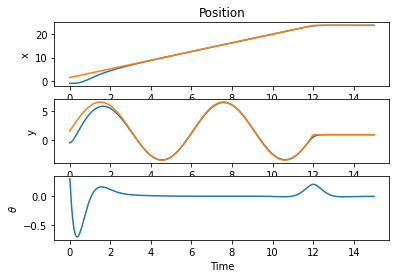

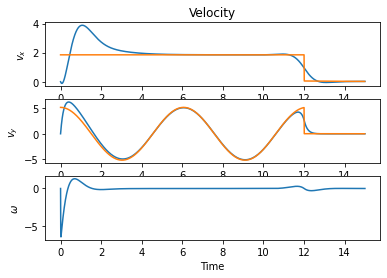

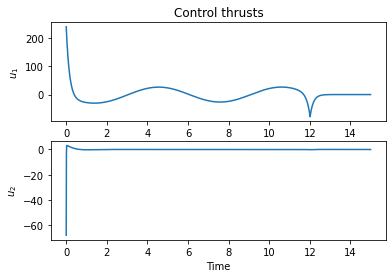

In [5]:
## Instead of using Linear Qudratic Regulators to track above trjectories and obtain global optimal controls
## here we try to use Quadratic Program solver with constraints 
# Try first trajectory and it will take 7 iterations.

# create a 2dquadrotor
quadrotor = Quadrotor2D()

horizon_length = 1500
det_t = 0.01

# 15s simulation in total: 12s tracking plus 3s keeping stable
simu_time = 12
terminal = int(simu_time/det_t)

# 1st path: sinusoidal wave
z_des_1 = np.empty([6, horizon_length])
for i in range(horizon_length):
    if i <= terminal:
        z_des_1[:,i] = np.array([1.5 + 1.85*det_t*i, 1.5+ 5*np.sin(0.33*np.pi*det_t*i), 0., 1.85, 0.33*np.pi*5*np.cos(0.33*np.pi*det_t*i), 0.])
    else:
        z_des_1[:,i] = z_des_1[:,terminal]
        z_des_1[:,i][2] = 0.
        z_des_1[:,i][3] = z_des_1[:,terminal][3]*np.exp(-3*(10**-3)*i)
        z_des_1[:,i][4] = z_des_1[:,terminal][4]*np.exp(-5*(10**-3)*i)
        z_des_1[:,i][5] = 0.

#initial state
horizon_length = 1500
z0_1 = np.array([-1, -0.5, 0.3, 0.,0.,0])

Q1=100*np.eye(6)
R1=0.1*np.eye(2)

u_len = 2

# constraints
u_max = np.array([10.**6,10.**6])
z_max = np.array([50.,10.,10.**6,10.**6,10.**6,10.**6])

# z_2,u_2 = solve_ricatti_equations(quadrotor.A, quadrotor.B, Q, R, horizon_length)
z_1,u_1 = QPsolver(quadrotor.A,quadrotor.B, Q1, R1, z0_1, horizon_length, u_len, u_max, z_max, z_des_1)

QPtrackResults(z_1,u_1,z_des_1,horizon_length,animate = True)
# animate_2Dquadrotor_2(z_1,z_des_1,quadrotor.dt)

     pcost       dcost       gap    pres   dres
 0: -2.1921e+07 -5.2164e+07  5e+07  3e-01  9e-16
 1: -2.2008e+07 -2.8040e+07  7e+06  3e-02  9e-16
 2: -2.2040e+07 -2.5105e+07  3e+06  1e-02  9e-16
 3: -2.2011e+07 -2.4881e+07  3e+06  8e-03  1e-15
 4: -2.2017e+07 -2.4383e+07  2e+06  4e-03  1e-15
 5: -2.2019e+07 -2.3625e+07  2e+06  6e-04  1e-15
 6: -2.2035e+07 -2.2263e+07  2e+05  7e-05  1e-15
 7: -2.2038e+07 -2.2082e+07  4e+04  1e-05  1e-15
 8: -2.2039e+07 -2.2044e+07  6e+03  1e-06  1e-15
 9: -2.2039e+07 -2.2039e+07  6e+02  1e-07  1e-15
10: -2.2039e+07 -2.2039e+07  6e+01  1e-08  1e-15
11: -2.2039e+07 -2.2039e+07  7e+00  1e-09  1e-15
Optimal solution found.


<source type="video/mp4" src="data:video/mp4;base64,AAAAHGZ0eXBNNFYgAAACAGlzb21pc28yYXZjMQAAAAhmcmVlAAC/hG1kYXQAAAKvBgX//6vcRem9
5tlIt5Ys2CDZI+7veDI2NCAtIGNvcmUgMTU1IHIyOTE3IDBhODRkOTggLSBILjI2NC9NUEVHLTQg
QVZDIGNvZGVjIC0gQ29weWxlZnQgMjAwMy0yMDE4IC0gaHR0cDovL3d3dy52aWRlb2xhbi5vcmcv
eDI2NC5odG1sIC0gb3B0aW9uczogY2FiYWM9MSByZWY9MyBkZWJsb2NrPTE6MDowIGFuYWx5c2U9
MHgzOjB4MTEzIG1lPWhleCBzdWJtZT03IHBzeT0xIHBzeV9yZD0xLjAwOjAuMDAgbWl4ZWRfcmVm
PTEgbWVfcmFuZ2U9MTYgY2hyb21hX21lPTEgdHJlbGxpcz0xIDh4OGRjdD0xIGNxbT0wIGRlYWR6
b25lPTIxLDExIGZhc3RfcHNraXA9MSBjaHJvbWFfcXBfb2Zmc2V0PS0yIHRocmVhZHM9MTUgbG9v
a2FoZWFkX3RocmVhZHM9MiBzbGljZWRfdGhyZWFkcz0wIG5yPTAgZGVjaW1hdGU9MSBpbnRlcmxh
Y2VkPTAgYmx1cmF5X2NvbXBhdD0wIGNvbnN0cmFpbmVkX2ludHJhPTAgYmZyYW1lcz0zIGJfcHly
YW1pZD0yIGJfYWRhcHQ9MSBiX2JpYXM9MCBkaXJlY3Q9MSB3ZWlnaHRiPTEgb3Blbl9nb3A9MCB3
ZWlnaHRwPTIga2V5aW50PTI1MCBrZXlpbnRfbWluPTEwIHNjZW5lY3V0PTQwIGludHJhX3JlZnJl
c2g9MCByY19sb29rYWhlYWQ9NDAgcmM9Y3JmIG1idHJlZT0xIGNyZj0yMy4wIHFjb21wPTAuNjAg
cXBtaW49MCBxcG1heD02OSBxcHN0ZXA9NCBpcF9yYXRpbz0xLjQwIGFxPTE6MS4wMACAAAAL8mWI
hAAQ//73gb8yy18iuslx+ed9LKzPPOQ8cl2JrrjQAAADAAADAACNeCrh/uMdsT2wAAAK4AFvpH8E
LY2vMAnVN747X9YU6COah5mpiQjMc1aKt2JTVn/jU/u1ZAs1VZOpvPka1f5PwjdNy3eZU4s3lgJv
W+nbNwU62G3t1ge/zluZkV4UcLmRb0z8VNKWKSX+jaGKw9JvLNVGhtGyM1F7CKkdyF5r80myLHXx
48NoeZ/5mae2yTnN3cDxMpekqCdWiLKMW0ts0e4FEBs1cgFH7KXsnANWwVqU42EwQfVn8H+9NzS/
24cXBiqT19eSO8uS8bZWhwO35vv1UdgyLEkIhuc2QACyUdbi4sswfgALceAVCguoXZ7Yvlrf/NT6
twcrEj8s5KJk+yGh5RsgeEHX8jY3OdhJyVd7zRENQD/p8hP+eWyLt2KicjJfr8Q8KmoR5XIyozpa
ZmHuNoc1FnHOW7BIXU0Palx3dm3FdKPM8OBU1fDHgO9mS0/dXXjri6XDxI4bDdEzTV7fXIIxgOUU
8TWcOMrjTjA0Icemp9DnSnCgnwq4SkCiiHgT+ja6neqWtL531+YpDNgl+H7qZfmWLqVOdmsEoGHw
FTWm8L0iTmo1qpLnRPjrzKgVcxVQRaL4zIJbUfvQrcU6xPt+u2HEm/JqP/VnCh8aopOD6tCFHtrB
XyyoB1yFxVrKl6tlMPiNvcAMavgt/XDZSrE/1rqGSh52hIyTIK9CBzoUqCYmGwZ2n2/AOljxhAAA
AwMsZuxDYi44YmCLsFoDQoj6j4aRZljJZhpB3jZTeb6BH6yjtFQqTCamPDM16oYpRMJDNHP/xAwd
AbWVzv1+f6VRzppdhYIcckReAMB68aKVfgA+vp210iLTBjJ/VcetG7kCwNXrHJAT5R4/AV3ku86s
Bqo3CtF5aRT2g6J2+Ir3rLQl0yxfsRGM0aT2p4prmYGjCGqatZ4JYfTZAv6L57Ws75/+YWy3xWi4
SqHcrOSMQxyI505lnjjdmr7P7ji1+mdmqo4FolOqMxtQ5P+F7tewyfiblwXd/iD3Tae2slH3+J7K
QaSNNF/vjzTjU+A/xpoHtkHr/e1ccpTiVNzb/TJszqks/YfUkgABvOoDJwLfxlhs7Q64VCAYPa+w
qJURD8pWnvSzpaKpAANtlTGOb3fQfxhA1ZiAAirBnK3hk/crM2WhZFJOgiTJUGfBHGLrxWh9aWOW
begRTmUGmvbxWUqznoGfQUFQje7uNF0Jzwdtwirk62UnmH1LUiy9GCuIVbB9UPxLaParQEbLp8hb
QZzxoEsOaFfalQlOh9F7QaGMUM/NrJ4qsO0GID6fcPc7mf9bEiihI7/jP/uV+UEgmtVR6ATdhOIP
xtajr9jr+bHL1DwO5zOJgPP0vKj8WeaPNnBTQlE+bFH5IOVsaI2bM4MZAjo2rgxE//mdrIBOp+6I
KRBFECnkomCsGt9U/wvO1nndX5uCaXi+dprpZvv5bV53sX+9WEfHi6pYUqpJB11dBpn1j8t1w4cA
AAMAGmsRWFgMUu8YjjTj8FnDEexNzdUlSu/yqe5qRx9m9EqBGJqkoMCZ6N+RGa9Jl/QhAdEJHJld
6JhP8cZzU31hWa5tXrY2VrQWTjLhJ5Jf5RtkClPOJPw/XOmgF6pPONoBH3ggveZ0mqd5jnKAc9+Y
+0kGGsFJe7Kq05xTXJVYmk32Ee80VM3z4jL54xMrHf9eFZXvRwGwbvnRHX56AK8sdNsF1CkYRAEe
4chdgsPrz0XF3JGuwBvTjSQGy4fOpfZFPmZ+hUdKMsKWV0h9ThrJuf6z4DTNkUSuTy4C/QNLhoIr
gwo0EX6iiNCsY2JZ+PwO8PpOQ415xrMoOEAYeisrtholRhvxmlOggRyxIERtfHLkoUwwPsnbgQGU
URcEd1BQU/rQDEFP9dapZXzQyyPIVBqsvuUTN9mjw+rfUSyffemqoPPcGPAT2aeasvTKdplQRqF1
RiyQuu9L03w3/J4IjBw5vfhxDmBGlMTrgqpDuDuR2nOOyjWctjuI0Vdg8v7EAJy+5fx+23LatWBL
tqqlTxay6kBqhaNmPDT6UgFhmlIqdpLnJHV4jff8sR90V8DZUHpJMzcdL16HdyKRcAAACT4x9wMX
vk6r1+DcNo70Zgi88Df83P3fGgCVzssfqtVicJkNRXr+50jkltbkiwBqPTj4IMy6Gk3JoO/cNUiK
Bf71vvXMmoiGAgeLzsPSM23LwGlui3Q7dFX21f4dHuSHUsXyN/ibY95fjHPJtbNHicFMaXDcW1Ol
k9tLYuYq0NNGBfOeVHp4HtugEYi4QzKLhGO3s7sF6JkwJtlvU1zkxyvMCXNLDckJWbTFTpODWyEs
eBRktNXj59G96ucJaaOJEV8GUM75HMuvsgwJ4PRXVp7kda+GAmadfGxB5dKACYmoWqf/uAAIRp4x
IBShZNLHljhJ80GRprrRcfDMTMcYiSgrJnByWapJlcxH3IPa6XvEoAAACbAIOJXRlnuC40f9uyzg
IEUsToC82Az5FJlSUdBrEAF6J2nCQtHdZI5dgXvPUXaz5KHP4mMkyRLV/aaCglJA9NdiLde0AXyg
FrHQpuEtaqu5RPHmDnSj9upEz+6ACe2H/EudacjFUucyFWxCf6H/vwKXItw4o46/ius5XHhsOosf
EQubRFj1quiTd/0r4ijsCdHZUZQOmiaGqEl/x5MuHk1fDSNOyB+Vb3fHatNBj28pwHgpHyGnmQpl
zrqJ37iToXYF0+0A174qzUwVCd0gSPpeGGpIOrh2kgVGtqk4m//9kyBab7lSmkezfxM/K9hspOjq
LX+fTNdH+Nt1kqoFFbyQKsyp51eSTZLaOgU07oFoGtrhFKSJaKW+y6jY5HKqkOWAqDlZaynsLSco
aebxz2aGUIL2Ub+HF8zS9

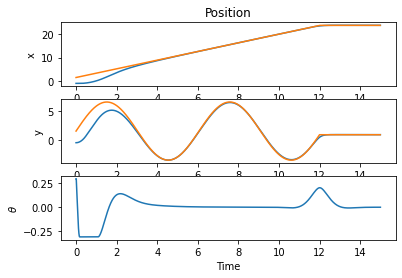

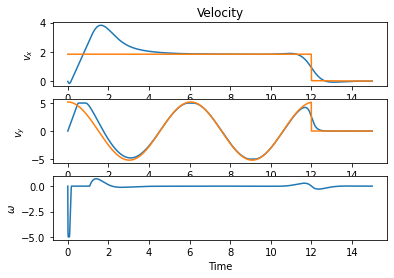

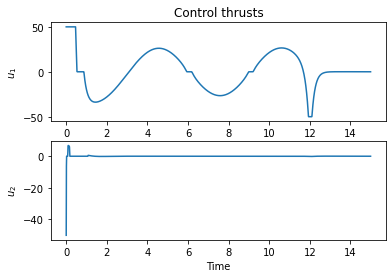

In [6]:
# Then if we add more restrictions on velocities and control thrusts

# It will take 12 iterations.(Please wait)

# constraints
horizon_length = 1500
u_max_12 = np.array([50.,50.])
z_max_12 = np.array([30.,10.,0.1*np.pi,5.,5.,5.])
z_12,u_12 = QPsolver(quadrotor.A,quadrotor.B, Q1, R1, z0_1, horizon_length, u_len, u_max_12, z_max_12, z_des_1)

QPtrackResults(z_12,u_12,z_des_1,horizon_length,animate = True)

     pcost       dcost       gap    pres   dres
 0: -2.2507e+08 -8.1765e+11  8e+11  3e-06  1e-14
 1: -2.2447e+08 -1.7212e+10  2e+10  6e-08  4e-14
 2: -2.2482e+08 -4.7960e+08  3e+08  8e-10  1e-14
 3: -2.2510e+08 -2.3653e+08  1e+07  4e-11  8e-16
 4: -2.2513e+08 -2.2597e+08  8e+05  3e-12  3e-16
 5: -2.2514e+08 -2.2522e+08  8e+04  2e-13  4e-16
 6: -2.2514e+08 -2.2515e+08  8e+03  4e-14  3e-16
 7: -2.2514e+08 -2.2514e+08  9e+02  4e-14  3e-16
 8: -2.2514e+08 -2.2514e+08  1e+02  4e-14  3e-16
Optimal solution found.


<source type="video/mp4" src="data:video/mp4;base64,AAAAHGZ0eXBNNFYgAAACAGlzb21pc28yYXZjMQAAAAhmcmVlAACXJm1kYXQAAAKvBgX//6vcRem9
5tlIt5Ys2CDZI+7veDI2NCAtIGNvcmUgMTU1IHIyOTE3IDBhODRkOTggLSBILjI2NC9NUEVHLTQg
QVZDIGNvZGVjIC0gQ29weWxlZnQgMjAwMy0yMDE4IC0gaHR0cDovL3d3dy52aWRlb2xhbi5vcmcv
eDI2NC5odG1sIC0gb3B0aW9uczogY2FiYWM9MSByZWY9MyBkZWJsb2NrPTE6MDowIGFuYWx5c2U9
MHgzOjB4MTEzIG1lPWhleCBzdWJtZT03IHBzeT0xIHBzeV9yZD0xLjAwOjAuMDAgbWl4ZWRfcmVm
PTEgbWVfcmFuZ2U9MTYgY2hyb21hX21lPTEgdHJlbGxpcz0xIDh4OGRjdD0xIGNxbT0wIGRlYWR6
b25lPTIxLDExIGZhc3RfcHNraXA9MSBjaHJvbWFfcXBfb2Zmc2V0PS0yIHRocmVhZHM9MTUgbG9v
a2FoZWFkX3RocmVhZHM9MiBzbGljZWRfdGhyZWFkcz0wIG5yPTAgZGVjaW1hdGU9MSBpbnRlcmxh
Y2VkPTAgYmx1cmF5X2NvbXBhdD0wIGNvbnN0cmFpbmVkX2ludHJhPTAgYmZyYW1lcz0zIGJfcHly
YW1pZD0yIGJfYWRhcHQ9MSBiX2JpYXM9MCBkaXJlY3Q9MSB3ZWlnaHRiPTEgb3Blbl9nb3A9MCB3
ZWlnaHRwPTIga2V5aW50PTI1MCBrZXlpbnRfbWluPTEwIHNjZW5lY3V0PTQwIGludHJhX3JlZnJl
c2g9MCByY19sb29rYWhlYWQ9NDAgcmM9Y3JmIG1idHJlZT0xIGNyZj0yMy4wIHFjb21wPTAuNjAg
cXBtaW49MCBxcG1heD02OSBxcHN0ZXA9NCBpcF9yYXRpbz0xLjQwIGFxPTE6MS4wMACAAAAMHGWI
hAA7//73Tr8Cm0WXagOSVxAv3W2vCrD/YEndOjYAAAMAAAMAAAMBC5TgVTdZidjOAAADAKwAHog/
4QtNZUADbERajgG2wmbcK8GHQpxuef5Crs9EQ5k4/pZiI1kCzVVk6m84utmql+CN03Ld4mIZkKX1
36307Zs9ZYFTU6sD3+ctzMciIJZJrIKXvvSkKXOLv5DNXxyuuqKUfn2PLhYjAaqGLLdeMicBClNF
0AsjESWxHh+UY9rS6w2uW+N95+xrqrsKAilZG+6/sIcHeTz3PoPXbZAFGK4LfupslFVnxc9AvCIo
Z/FgMLu/rI+uI5Ra0cHUTaCYVCdmiFmIw/u6mA7O/Z7ilZRr3YyNyxwOTZt5y55+78B6Ln7uH8wD
SoAADxIWN7Uo/VCHKC/Mlro9YzTuz6rtF+JcoUSwzHW7D7a/6VTwiD2BK/5MLCnLiLpchP+eWyLt
2Kicfwxr8Q8KmoR5XIyozDaZmHuNoc1FnHOWYs/Vhoe1Lju7NIz1ey/elcXPwR1ojqQ6SXXyxLg3
7a7WmF/3oLfHMvw9khmXeKAkzuwDMHw+cno7UZpohMHNGAPfx44A4aoisU6U7jkfSzlO+nTN7RRn
QPH2ezIGf+IGjazaYHgFEyaBh5iaeqh9mo3hF9MvXj1noUngfo4fesnB8t9zSfx6umOEJpl/m+ER
Sl9+N6MSJlJYlMYh7iMv3c3Gd0xPuIpw7v9xo8DFbWhLn51prG7VRXyh6+qRhXoQYKNJGjNUOqlW
ZSUbsgmhDJJ5TvlYMjTVRMAIoXLCB63sHLgTBXgO8cNC75S6RU6cSkz0GqQBx/Z/syZXvzJ0rsS8
1IzWlpHIydA53Woq9AfwKfJMEhmjn/4gYK/itGMx9fn+lS3CPAHRiDjkiLwBgPNYl4XHubUNdqci
HkjSfKPC3JCFwmcRLBy4H5+nbdDmigOfEoTyWfWfNMxdkHhi70pqENX06SyJx5dAo9yxaQzzcCBS
9UTmemKNZiczzZD65yxXUd/1yQ/8NMW1Aj0hUUhobRRhmLv7Uaw54YXzt2U9z0S6YnPDZz4AWqsq
rAkh3Ja5BbdvNoHeh8UkoH9bOkpJiPk3QyfSfVycdAAAJxktP8YDsa/LgJgcfkD+TKOBqzlxYyMf
haqtBnhP8g0Ss+DT0J2XCahzHq4Idzuxm96B6GFfBDEu/1b9rH+Tv6Vd+63Zz65AYRSEAACEkJFf
rTlpiA+tcyofd4XRdqAN7i0FZhJ/Sp+dLXFGajTvkGeTWjTiACqtxuDyDjPUKe3OnPgVAQeaMAJQ
+72+1nWGF5etiAy7tWeevNXqCGkkqqfkw1ceYDEAo79gA8h7AHQp406NdTAi0GEm8cC5+aHIHcrH
nqQDbqTKv7hNbdD6RpuTnA7pD4klHfB6JWGakdyx3ZAfEgiRDtSj7CbmMCGYudhDTit//1/Gf6c/
gVGp2iwiYOumxKmFNooh28TOaADLTJKiU2g+R0xYbgc8cKTkxzeMDWRqTFPftoJ6NAM/LXRJD6WN
/Wdv/SBSmSkjaXXnge4cTg7FsskNWJAYL+trRBL38/U4g1aXl2nFZxcVJoSwARfLnmb9sotQvrDJ
n5Jz+h6HLwSAHky7/UKPLgOKhWWC/qmspFcpama848TQDLmYsrjo2+/8kymuB2AdLf53DjCxJzrE
69NXaH56CecNvqiqvSuTu+VHgR3Lx6X5S8xP6b0bkJ2yzhg+5pyICm+lyJtjpw+E91vkkvj/YIO7
6C2JAGEDcTWdbpOglWvbTwdkhrLrmBMk5Q3dSMGrjaTArak45R9e/ERU32CY7JSe4xu2GRP2Vrp9
l5PK3kOQnpLcg000J84z3QuLpnaBn68kEkJsWgNuv3Lfd5uO9VR7GEJ0/vM/ieWU97Ivh1hHhbpY
JGiWfS1qSj/kJ65ECaLY/wVTaaqauIzLP6gQvihYdJ5wVmbKAWyIhs2wBkctwStvn8iSoWp6nLmH
5oDDjSVF1yA6llEMGQb8l0ma2ccQZdNxTt4DgH1v+oJFgcq1B15NI9dRdTw/w9JQQxvY/Qf2YSKn
Os/gem5EXqf7Ivr2UdcV3brWdVLUnhaH+tHhku7Gfm1ht7xNyN85bzmvkF3/b8fAo1BunpLrMoJZ
icX2JoqzW3Gca+2yjxB+cheuPisJbJ486i/mmNwbQy6YRBaQUurUtsV7e19jC/eRoAQE+d8C3g84
qFgsShaZQAAAVGPAf33/EsQLNBj0E++BlgDA5Fx/z6cNU4B2brfGaY+BSh3QQIUJyAf5D5DMm3l0
J8cqxvrUlS16LGffVflMgmQavHoAVgAGJ6mQSQ15wrx6Ih8qvfcowE/KIZcnOgtWwgU9XGhhVcno
wL56/s9rCq13kSlvVIdJklPwbYkSxgS/KtnFMFfsQdTxFKPT/cXAmKnQmR51gDjeaogP4f9NK5d+
dNxeoYeB8f5K0u/g06cd2EylkZ0tJzn0g+whBxBkkhuBJC4/8QAKSu+rhpkz7JzVJa4p8j+RprsF
2uHHM2Rm93dhN0VO+2Ngtn7ZGP+6UHIXhuAAAB6AFNWaMOeIMZ9ToTlPtyQf+5wyX+Ytk5sZmhyg
msL9IFSufNHMhFnCIpx0JVkdZ8ny293+awwJGg630FLM5Z5QERkym9ngDwFr7IbZjEwJuJKePL6C
3a54VG5r48E9uds0hT2Dog+HtI98avtVdmF/hPoYqINvI9sN+pRRhFcKe5iKeurr/D5sAmee+NsM
dCVQwVYT/bA6WoqqEl/x5Mx2Bxe2KNNx8RhrsVnatNBj28pwL6SAkNPMLIaEKpswc2RZWLLkQYEA
1743svKm0D4wH/fZLQPX83DtJAqNbVJwKf/7WZ1NQU/rglau8tRaL2GgrTVYL+dgxro/wxoslVAW
JZjVPplYHt9mEfazvZ3Ac

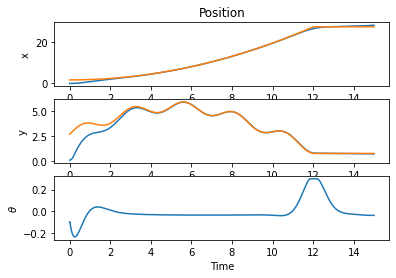

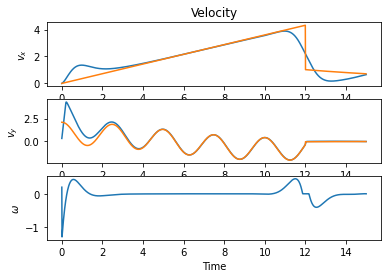

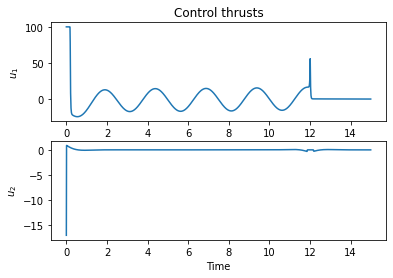

In [7]:
# Create the 2nd trjectory which is more unregular

# 15s simulation in total: 12s tracking plus 3s slowing down(keeping stable)
# It will take 9 iterations.(Please wait, it takes a while.)
horizon_length = 1500

# 2nd path: unregular curve
simu_time = 12
terminal = int(simu_time/det_t)
z_des_2 = np.empty([6, horizon_length])

TR = lambda t: 0.5*np.sin(0.8*np.pi*t) + 1.2*np.cos(0.05*t) + 2.8*np.sin(0.3*t)        # lambda function defining R(t)
dTR = lambda t: 0.4*np.pi*np.cos(0.8*np.pi*t) - 0.06*np.sin(0.05*t) + 0.84*np.cos(0.3*t)        # lambda function defining dTR/dt

for i in range(horizon_length):
    if i <= terminal:
        z_des_2[:,i] = np.array([1.5 + 0.18*(det_t*i)**2, 1.5 + TR(det_t*i), 0., 0.36*(det_t*i), dTR(det_t*i), 0.])
    else:
        z_des_2[:,i] = z_des_2[:,terminal]
        z_des_2[:,i][2] = 0.
        z_des_2[:,i][3] = z_des_2[:,terminal][3]*np.exp(-1.2*(10**-3)*i)
        z_des_2[:,i][4] = z_des_2[:,terminal][4]*np.exp(-1.5*(10**-3)*i)
        z_des_2[:,i][5] = 0.
        

#initial state
z0_2 = np.array([-0.2, 0.1, -0.1, 0.,0.3,0.2])

Q2=1000*np.eye(6)
R2=0.01*np.eye(2)

u_len = 2

# constraints
u_max_2 = np.array([100.,100.])
z_max_2 = np.array([50.,10,0.3,5.,5.,10.**6])

z_2,u_2 = QPsolver(quadrotor.A,quadrotor.B, Q2, R2, z0_2, horizon_length, u_len, u_max_2, z_max_2, z_des_2)

QPtrackResults(z_2, u_2, z_des_2, horizon_length, animate=True)

     pcost       dcost       gap    pres   dres
 0: -1.7015e+08 -1.4620e+12  2e+12  7e-06  2e-14
 1: -1.6685e+08 -4.7359e+10  5e+10  2e-07  4e-14
 2: -1.6749e+08 -1.1312e+09  1e+09  4e-09  2e-14
 3: -1.6979e+08 -2.0854e+08  4e+07  1e-10  2e-15
 4: -1.7010e+08 -1.7341e+08  3e+06  1e-11  1e-15
 5: -1.7014e+08 -1.7068e+08  5e+05  2e-12  1e-15
 6: -1.7015e+08 -1.7031e+08  2e+05  8e-14  1e-15
 7: -1.7015e+08 -1.7017e+08  2e+04  1e-14  1e-15
 8: -1.7015e+08 -1.7015e+08  6e+03  1e-14  1e-15
 9: -1.7015e+08 -1.7015e+08  7e+02  1e-14  9e-16
10: -1.7015e+08 -1.7015e+08  8e+01  1e-14  1e-15
Optimal solution found.


<source type="video/mp4" src="data:video/mp4;base64,AAAAHGZ0eXBNNFYgAAACAGlzb21pc28yYXZjMQAAAAhmcmVlAAEAI21kYXQAAAKvBgX//6vcRem9
5tlIt5Ys2CDZI+7veDI2NCAtIGNvcmUgMTU1IHIyOTE3IDBhODRkOTggLSBILjI2NC9NUEVHLTQg
QVZDIGNvZGVjIC0gQ29weWxlZnQgMjAwMy0yMDE4IC0gaHR0cDovL3d3dy52aWRlb2xhbi5vcmcv
eDI2NC5odG1sIC0gb3B0aW9uczogY2FiYWM9MSByZWY9MyBkZWJsb2NrPTE6MDowIGFuYWx5c2U9
MHgzOjB4MTEzIG1lPWhleCBzdWJtZT03IHBzeT0xIHBzeV9yZD0xLjAwOjAuMDAgbWl4ZWRfcmVm
PTEgbWVfcmFuZ2U9MTYgY2hyb21hX21lPTEgdHJlbGxpcz0xIDh4OGRjdD0xIGNxbT0wIGRlYWR6
b25lPTIxLDExIGZhc3RfcHNraXA9MSBjaHJvbWFfcXBfb2Zmc2V0PS0yIHRocmVhZHM9MTUgbG9v
a2FoZWFkX3RocmVhZHM9MiBzbGljZWRfdGhyZWFkcz0wIG5yPTAgZGVjaW1hdGU9MSBpbnRlcmxh
Y2VkPTAgYmx1cmF5X2NvbXBhdD0wIGNvbnN0cmFpbmVkX2ludHJhPTAgYmZyYW1lcz0zIGJfcHly
YW1pZD0yIGJfYWRhcHQ9MSBiX2JpYXM9MCBkaXJlY3Q9MSB3ZWlnaHRiPTEgb3Blbl9nb3A9MCB3
ZWlnaHRwPTIga2V5aW50PTI1MCBrZXlpbnRfbWluPTEwIHNjZW5lY3V0PTQwIGludHJhX3JlZnJl
c2g9MCByY19sb29rYWhlYWQ9NDAgcmM9Y3JmIG1idHJlZT0xIGNyZj0yMy4wIHFjb21wPTAuNjAg
cXBtaW49MCBxcG1heD02OSBxcHN0ZXA9NCBpcF9yYXRpbz0xLjQwIGFxPTE6MS4wMACAAAALy2WI
hAA7//73Tr8Cm0WXagOSVwr3Ies64txf+EL4VK4AAAMAAAMAAAMAa8ZLf9ywySxnAAADAFYAD0Qf
8IWmsqADxuUWCdEIHEQ5tvN9EU43PP8hV2eiIcycf0sxEayBZqqydTecXWzVS/BG6blu8TEMyFL6
79b6ds2essCpqdWB7/OW5mOREEsk1kFL33pSFLnF38yz8RWaTeWaqOyZM15qL2EVI2mlyn5pNhTq
vjx4bQ8x/sR1zzs9/3Ywg6W/6SoJ1XokUnXC2zOKRLVByVx9m/qY1DcA1a5jCI5/bPp9Wfwf703N
H/aBtPDupLjXhJoKt5JCFaHA7frQ21h6CMCg3BWgfuAAW+jrcXOHgvs4IQBjMN/lcPti+U1CAcFp
GVLixdN7iDoZCgaHlGyB4QaTpSDc52EnJV3vNEQ1AN+nyE/55bIu3YqJyKjGvxDwqahHlcjKjO5p
mYe42hzUWcc5ZMwhdTQ9qXHd2bDV0o8zw4FTV8Md97oZLT91dd8E+qep5wwE0g/9qrhgOgK/OQDo
TAmCKn6HQmoW73as8mIBByGr+BY2CUqxFS8tOZEmQ6HV+K+OZDcisxOtLPkKVz2L7m7lzamvIo+V
niqH9QSJtJkJ3USmVGR9IfmGrNu6e12w4k36nf/GIYpYH+UvyndGbVY3sCUKyfXIXFWsqXvL37vy
vZ4BUvNUWViVj2jAfyv8P+F/xA0SwCRyiEGChVLRWLWSvSYmvhfT1WcAAAMCzEJDeaFpoDGENgbe
84r4Tb7QpWBhzYANIW3XXZ0Am7IxWi0h/SF3xjwzNeqFJITCQzRz/8QMLNceyud+vz/SqOdK6NDB
7ZOqLl/wTXUp+oNiF+eIjCSM04Cw+wpZEIcOi1jnvgDwiqnxZEueTPmAxelYIZgkk8glhmNnNnfG
8V1TDh24+mrqj4DZAUsqazrpYjzcZR0QQxg9o0f/wAD+mv4L4KHJrQbnftkEqje6WyzaV2g2SCVx
/LUcZ01StaVW8m9qZfTXykQKex27/JRAtUQdZKPv9nh0Z0D44AAXe59FpoCBrprDAVkMZNMAqwM7
nSmBi0m+AVtc3eOaGO+f0t9D9HZy6Qtf+1IHYRdaBqqnhFotfxzp5Hod1XIhmVsMrTzTnZsZOEHE
aQe1zV7oQXzMCK+Pw4IsG5KtN3kyraR30j0O/cPUIOk18G2wxcSSHG+bwju2yfJG2ELZBF6uEbAT
B7Q/3F40xgms7iWnmXLqAsR96GkiFUcOWS7wXuGGZgBnFIydTyNO5tLyBo07YKobMvj0kuGFK1Gv
aR4AASVVYBnP9brrq2eOUYT64OiIl4E1NQpcKYQShuIRqcM+SpvNltbpMKYk6NIhXoADDHWWp/rN
gubRpqhN1nYcZvgExqithzjGbZP2VZY8ggKitYYOcQ5QH7iriLvoCMxIwrvaStOvH1+0oSOh+bQv
3TK1GKD+qMezzJzO9lYQF10axnAGwZONpa00IvzTbHSWstB/+LcOsyH2h2nDJpvi+DA5AOfk/V4u
0FSuUvM2IgpyjyAwbf0bf+kd8IB5z9/giD+WlZ5CZn8UvgPcgRTJWvn2nkJHi6E2eaq0x4w2oxJ+
8W7y9eadS97xH0fyqQtNrY/3jcSDnZREMX6+h+9mOlxrKjoUFyjHlQsLyBIHe+nBw4AtZxXZoyiG
gq3LflFp1YPzJHwwAAADAGh3jhQh7glaoGs0iygK18prHKSroN3X+XsKR8cuIGS//OVYi/WZirKJ
xDDgACJ1dKiMjdGrLS7JmwcJrLavHH+fdMifPb9LK0ZnFPm431n4ndMZmwg74E6YhqsSU1xscIC+
nKDf3qpHfpC1hkV1MxuNEk2Z9FBLR57SBaSgQpLaC/QIV+RyR/mWk5GLH4+McSNDZpZchkg/mjtN
9M0lY7Kptk+5wDQEcg8dKffvKAj4XVW3MYdSN5IQuVGKUlZy/yHUY9DFSKSVTANty9AvPl72K7Kf
owIyXapUptnhcA2sLmZ1l5paKCiP1FchSvxahm9/NY1+bwEGNvqLF7TeFPhTYloAAAMB1XXR/c0F
rgBHCPiI+cS8TrbFRhmZ0Fek7DrKwj3Ii/1VQVOGjr3WQSqkVCNaLuFCZipxLz//XPO/3jg/LkfS
uW/VOdsdEUh1tcJ8BllU9dWhDjE+PREPlV78N3yT+cehxuLanSwl1Xnr9Nxt2jAHwportIr7boAi
/6C7fx2RUfbDGgtp//2TC9RKBIBPEyFge+ch00PHjlzcLzT8zfrv9U8algn/1iSYi+Upu9+480Zs
CS1xaRrH8LGNeu/JjPMM/Z8JUwHH/s4BvefXMVLTAFLLiqFF3TmZaKHgJkh4rOSk/sn/xhAC0TBJ
38MJf2w68J/qivAxNdoNVfMcgm/3fNSjLb46ailoQUkSgWBHgOjeMq0K0Q7FABMv0ZFFcoJfLrUM
3/OPPGByrhJyBBniBIfhbdRNMctX79+7nD24Rq5z5EYbSl3IYtBWGqhr3EHqYMdxqZg3wJHupKPU
mLpcD7tYXRn+SeDG2fHIU3rvOuYCYTCX/EOE3YCG2FCgQXRiyy6xxxMF0h6ajluP2MM+ADukKFna
2EA/lIK8cc5MAbltmZrIgKtBEKWfgo+ODglyGnBBp8YmpZ90kGNJHyhYdftkGnkS9LE6LSeI1XXZ
Q93U9vKe03S06HTFHtpFFzPASsrfZXcZ9vPogio8fKQ5kcHw9xa6YXxiB52D/6DLI9JdSA+ECcDC
vX//m7dSFqPADKYPfOuQeVC49Xknqv/mhAUBXpVtiLySReME05uxgXtJpOVWmV2ntQRhiMSvYACw
t1wfOG9bakTS5obYPuEcV1rSuc7SSOFFU5RMnzwyTdavqRIef7NYEBrd74lFAtPy9WWVp/fch2X9
B7huVpEDiV9M/rpa1f9Hi

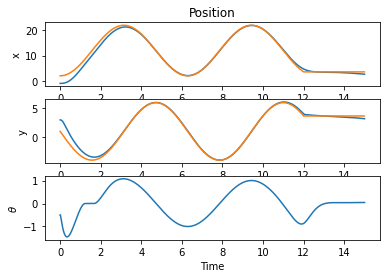

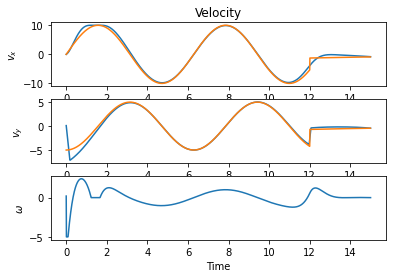

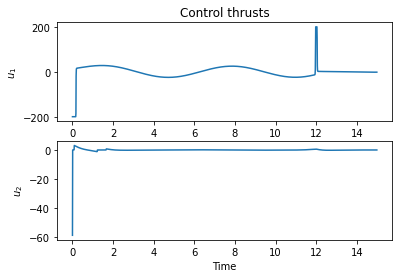

In [8]:
# Create the 3rd trjectory(ellipse)

# 15s simulation in total: 12s tracking plus 3s slowing down(keeping stable)
# It will take 11 iterations.(Please wait, it takes a while.)
horizon_length = 1500

#3rd path: ellipse
z_des_3 = np.empty([6, horizon_length])

for i in range(horizon_length):
    if i <= terminal:
        z_des_3[:,i] = np.array([12.+ 10.*np.cos(det_t*i + np.pi), 1.+ 5 *np.sin(det_t*i + np.pi), 0., -10.*np.sin(det_t*i + np.pi), 5.*np.cos(det_t*i + np.pi), 0.])
    else:
        z_des_3[:,i] = z_des_3[:,terminal]
        z_des_3[:,i][2] = 0.
        z_des_3[:,i][3] = z_des_3[:,terminal][3]*np.exp(-1.2*(10**-3)*i)
        z_des_3[:,i][4] = z_des_3[:,terminal][4]*np.exp(-1.5*(10**-3)*i)
        z_des_3[:,i][5] = 0.


#initial state
z0_3 = np.array([-1, 3, -0.5, 0.,0.1,0.2])

Q3=1000*np.eye(6)
R3=0.001*np.eye(2)

u_len = 2

# constraints
u_max_3 = np.array([200.,200.])
z_max_3 = np.array([50.,10,10.**6,10.,10.,5.])

z_3,u_3 = QPsolver(quadrotor.A,quadrotor.B, Q3, R3, z0_3, horizon_length, u_len, u_max_3, z_max_3, z_des_3)

QPtrackResults(z_3, u_3, z_des_3, horizon_length, animate = True)

     pcost       dcost       gap    pres   dres
 0: -1.9538e+08 -2.0989e+12  2e+12  4e-06  1e-14
 1: -1.9420e+08 -3.0366e+10  3e+10  5e-08  3e-14
 2: -1.9476e+08 -7.5417e+08  6e+08  1e-09  7e-15
 3: -1.9608e+08 -2.4924e+08  5e+07  9e-11  2e-15
 4: -1.9634e+08 -2.0229e+08  6e+06  9e-12  2e-15
 5: -1.9636e+08 -2.0056e+08  4e+06  4e-12  2e-15
 6: -1.9639e+08 -1.9678e+08  4e+05  4e-13  2e-15
 7: -1.9639e+08 -1.9643e+08  5e+04  4e-14  2e-15
 8: -1.9639e+08 -1.9639e+08  1e+03  1e-14  2e-15
 9: -1.9639e+08 -1.9639e+08  2e+01  1e-14  2e-15
Optimal solution found.


<source type="video/mp4" src="data:video/mp4;base64,AAAAHGZ0eXBNNFYgAAACAGlzb21pc28yYXZjMQAAAAhmcmVlAAFw8G1kYXQAAAKvBgX//6vcRem9
5tlIt5Ys2CDZI+7veDI2NCAtIGNvcmUgMTU1IHIyOTE3IDBhODRkOTggLSBILjI2NC9NUEVHLTQg
QVZDIGNvZGVjIC0gQ29weWxlZnQgMjAwMy0yMDE4IC0gaHR0cDovL3d3dy52aWRlb2xhbi5vcmcv
eDI2NC5odG1sIC0gb3B0aW9uczogY2FiYWM9MSByZWY9MyBkZWJsb2NrPTE6MDowIGFuYWx5c2U9
MHgzOjB4MTEzIG1lPWhleCBzdWJtZT03IHBzeT0xIHBzeV9yZD0xLjAwOjAuMDAgbWl4ZWRfcmVm
PTEgbWVfcmFuZ2U9MTYgY2hyb21hX21lPTEgdHJlbGxpcz0xIDh4OGRjdD0xIGNxbT0wIGRlYWR6
b25lPTIxLDExIGZhc3RfcHNraXA9MSBjaHJvbWFfcXBfb2Zmc2V0PS0yIHRocmVhZHM9MTUgbG9v
a2FoZWFkX3RocmVhZHM9MiBzbGljZWRfdGhyZWFkcz0wIG5yPTAgZGVjaW1hdGU9MSBpbnRlcmxh
Y2VkPTAgYmx1cmF5X2NvbXBhdD0wIGNvbnN0cmFpbmVkX2ludHJhPTAgYmZyYW1lcz0zIGJfcHly
YW1pZD0yIGJfYWRhcHQ9MSBiX2JpYXM9MCBkaXJlY3Q9MSB3ZWlnaHRiPTEgb3Blbl9nb3A9MCB3
ZWlnaHRwPTIga2V5aW50PTI1MCBrZXlpbnRfbWluPTEwIHNjZW5lY3V0PTQwIGludHJhX3JlZnJl
c2g9MCByY19sb29rYWhlYWQ9NDAgcmM9Y3JmIG1idHJlZT0xIGNyZj0yMy4wIHFjb21wPTAuNjAg
cXBtaW49MCBxcG1heD02OSBxcHN0ZXA9NCBpcF9yYXRpbz0xLjQwIGFxPTE6MS4wMACAAAAL0WWI
hAAQ//73gb8yy18iuslx+ed9LKzPPOQ8cl2JrrjQAAADAAADAACNeCrh/uMdsT2wAAAK4AFvpH8E
LY2vMAnVN747X9YU6COah5mpiQjMc1aKt2JTVn/jU/u1ZAs1VZOpvPka1f5PwjdNy3eZU4s3lgJv
W+nbNwU62G3t1ge/zluZkV4UcLmRb0z8VNKWKSX+cMfwZrr6Cm359jy4WGwCqhi5uXjInAQpTRCZ
4sQQJpMgGNb6Q5GmD4hJh3d7l/bfDUicBwGEUwbv2QnaVE4i6pRD/tBhwv5WX010DcPpLnMyMCV2
sLWzX0v+T2b+/YWhaqZnMnxxop6O6lqf3cpzNn7r4dgkmfVoyfmU3ZuGLj9NCku0554Cb8AABAoo
8ga7vVCHTehQEvb54EcYtv5AHljlP6l2lAQ97GviSfycOjehTM0VDvZI6WYkRJ/Z47zYGt0LvDWN
wAeFTUI8rkZUafKZmHuNoc1FnHOWFYlp42sAuuFC13A73mtoebXZ8UXpft0dJLuo8LQL9tdBrX//
PzHCabe2v1kQlZT0rLdu8rZOyhh0KWvK7+uaJIfRE0bx9kDCB0nN7BwGdtZgur7UssIkDRAQ2xdv
64w91UVcH9yWmrSEy2x5ctPPSw7ZHDHbi99O6ibFxaB3e/sRPvD4Y8a8vLgr3ivIS5p0lQs45/pj
G57Kyy4s/w+OMO58OfIteK1awVfUVGoPGfVvOj+1iLKfKvG6xX0C96GrbAqwDFTxy7nCpNfAMqsC
Ypf6aHDYdmD8ziwbQAAHD9AO1Vbm2m41HfGskqd1eDgPWOZBQc0nngX5KljQ7IPs5fSSZcPzUVeg
P4C37Jxu4BZ/FN1CEmhZVTiS5/pVHOiOw+ee2Tqi5f8E0gZWVbczcvRjt8fbAd+lF1H0LBPQtNd6
lwfUJQbjCXpcLeCwN1mMkvpTw4ROIAnlzPFS03mLTqyLaz5ssP2AJH7AWrAea40B+aUvuMHier/6
oAmYp6gD776DOCDSmnIebbErJ2QJdzeq1Wsr0HRnXfUSQXaLws/H58FJ6xARa5RQzDrXI5OmCTql
C+sw/itzBmS3bR7AnxMd5lZnq+DnwPjjrWbRT/yCCCf6ghskKVJ+VfDX0t9D9BPYJM2tfCuaV9js
IbTvL936Fxrpm8tDuxQzm3Dp9KOwxOyp9bY+GKQexhkEEwWNB19DIka/UvHvbzJX/3K130jzoHZk
QIOj4tS7rn5IDzNSTA4IQipTttgAIe5r1cI2AlWNu9GT+/8tspt84w8AnpuV/w5D0WrF34VTbr4Q
prvbeK/dgsyhGdL9vYsT3oab94kZtjvQ2qV3voDDxyLHX3MgAATVCL++x3/LmT6phc4jBajK7vMk
qKSzjk0BzXfuihJOYRyVN5siFymMqIQnVyjZ04QTSs6FgP8JlL6zTIrWyghxP6DPMrbLFLy0Jqbg
VuKz21ZuPNcTsK5yX4dQPqPsqLqAEIW+3HpqaS/fYkuFg7xdS5HlOvJi+MmkrJ69QL9bx9/xAPCf
jG4njoGtFXg1TTIY+TB1oLx2QyLZLVwekRzDu0zQYsb2bRgGCpbCcHKjw4u5yy9+hdL1v+O+iaEo
DW+zPtxNlEYlMP4pfBFkxXhMX949PISPGormx4ImmpvH83DvwgVheWWhYhDScdJhBcy6O8R2BfIG
uTN/FFt1twbNnmC/9lLh3OokZE6O6wABTi3iirRhJxQDYumMViru+hSo9DpxaFg43ldYU6S8Ykxv
rPxPAOqDbHfAnTENT917t8KuPTAN0xDGEhCJfPl2i6EjryscXdFiLp/yO38qotQNd/861ZqXRuwN
gac+oFAKptCxZ3X6Z4RsuJoDoqx80sm/fk1VIY0KbWsTYmIIazCPzFxmy1rDbUgDko7VqK0qP7MS
oZwRg2tEz/H/hQIyZWy6leVc28zn9rDscMOnwU9oaogCHKNQnmQkQ0j6MfcKl2U2ZkcWStPfl7v3
YW253Bq3hUM392Agp0+30/uvax+YNptZIzJ7VFLIS9shvjU3zqq8kXs/+A5gRX79BhLlkUIZk4Ab
yY+2L25+dedUSa+0E1H70UrQg3mFZpc47LdMcXhc8ldvX9MO7WpaRP5gPPKoSKJkb1Sta7ppwqag
hw5jyUmBa09YWjUHcYt/xNOmwwUszehPz1MIQkti+552J7NMx3vwsmMARJF/0iOULBVBqCjdHXAS
RRPpjAmc93KMDbgp6SkvBz/jDzUkZwVXwYhSV3W+SiBgJc5cn2vboghjB8AcX/8YAUkRZNKGVDAM
IFQVBUf+0h0b2ReDXvltlXfajoUtSHPpkiAASFJPIhihh1T9fxn0VoSNrj+bUdG+d98TKqz/+/P4
dwpX9ApmG+GF3ZAFBAML3WValy0698wNmizCJtLoubZjF/u0b73fwBj1kmCmCvo8Sue1xAD1ebwA
AAMAG8knFuFw9oVAYAG+Tv3s1cA/CfnKcB52bt5ogYVEkzcprifIca6aEIBnqv0j283v28IuSumO
eevhdzv3FW4ABYZDiNgpMmcUe/6XMCL1JMdI98xn3Knh6qnaCtzdaDsLaFD6m8O+0YylmQVEnIxX
Fyat5Jo9VduC12v+XVaM9WS+Mzg4+/AGK7+Fynrq6/w+bAJd2n71Cd8WzW7squmhCqeqoSX/HkzH
s+RYjVDGD8J83UFi+urTJBeJSPB/5qE8s44ocC1ASaGlygydIgqjCJ9/EGsECcsnmvk/BtBterh2
kgVGtqk3qf/8eOdTV73U3GBXYrkzVHk/UlR1Fr/Ppmuj/IIkNlC1lenj7fEuSZm1snPOXm3M1fna
Ei/yHl74HPBSoJmqHUAoV2ZR5Q/PHbllyRDoAffGaoRxZNaLc0b/eVp0NYkjvfrIkkDa/0yrMKNZ
b2kSuRoGxRyRroUzYhywj

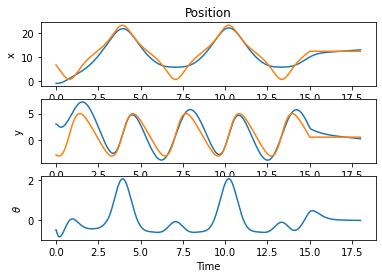

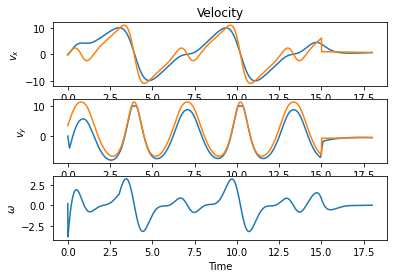

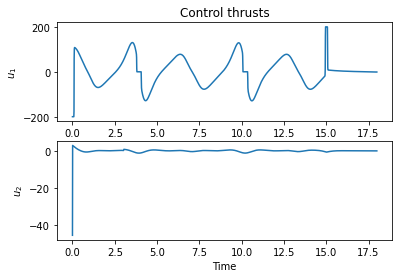

In [9]:
# Create the 4th trjectory(Lemniscate/Bernoulli curve: A "8" curve)

# 4th path: Lemniscate of Bernoulli        
# 18s simulation in total: 15s tracking plus 3s slowing down(keeping stable)
# It will take 10 iterations.(Please wait, it takes a while.)
horizon_length2 = 1800
simu_time = 15
terminal = int(simu_time/det_t)

z_des_4 = np.empty([6, horizon_length2])

# Define Lemniscate of Bernoulli
Lx = lambda t: 8.*np.sqrt(2)*np.cos(t)/(np.sin(t)**2 + 1)   # lambda function defining Lx(t)
Ly = lambda t: 8.*np.sqrt(2)*np.cos(t)*np.sin(t)/(np.sin(t)**2 + 1)   # lambda function defining Ly(t)
dLx = lambda t: -8.*np.sqrt(2)*(np.sin(t)**3 + np.sin(t) + np.sin(2*t))/(np.sin(t)**2 + 1)**2 
dLy = lambda t: 8.*np.sqrt(2)*(np.cos(2*t)*(np.sin(t)**2 + 1) - np.sin(t)*np.sin(2*t))/(np.sin(t)**2 + 1)**2 

for i in range(horizon_length2):
    if i <= terminal:
        z_des_4[:,i] = np.array([12.+ Lx(det_t*i+0.75*np.pi), 1.+ Ly(det_t*i+0.75*np.pi),0., dLx(det_t*i+0.75*np.pi), dLy(det_t*i+0.75*np.pi), 0.])
    else:
        z_des_4[:,i] = z_des_4[:,terminal]
        z_des_4[:,i][2] = 0.
        z_des_4[:,i][3] = z_des_4[:,terminal][3]*np.exp(-1.2*(10**-3)*i)
        z_des_4[:,i][4] = z_des_4[:,terminal][4]*np.exp(-1.5*(10**-3)*i)
        z_des_4[:,i][5] = 0.

#initial state
z0_4 = np.array([-1, 3, -0.5, 0., 0.1, 0.2])

Q4=1000*np.eye(6)
R4=0.001*np.eye(2)

u_len = 2

# constraints
u_max_4 = np.array([200.,200.])
z_max_4 = np.array([100.,50.,10.**6,10.,10.,10.])

z_4,u_4 = QPsolver(quadrotor.A,quadrotor.B, Q4, R4, z0_4, horizon_length2, u_len, u_max_4, z_max_4, z_des_4)

QPtrackResults(z_4, u_4, z_des_4, horizon_length2, animate = True)

##Generally QPsolvers have better performance than LQR controllers for tracking problems in this experiment.
##Plus QP solvers can basically solve tracking problems with more constraints. 